In [1]:
!capture --no-stderr
!pip install -U langgraph langsmith langchain_anthropic

/bin/bash: line 1: capture: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.2
    Uninstalling langsmith-0.3.2:
      Successfully uninstalled langsmith-0.3.2
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.32
    Uninstalling langchain-core-0.3.32:
      Successfully uninstalled langchain-core-0.3.32


In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY: ··········


In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph = graph_builder.compile()

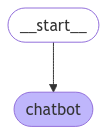

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: how are you today
Assistant: As an AI language model, I don't have feelings or experiences, but I'm functioning well and ready to assist you with any questions or information you need. How can I help you today?
User: quit
Goodbye!


In [3]:
!pip install -U tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [4]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Nodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as:.'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step . You define nodes to perform'}]

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [9]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [10]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

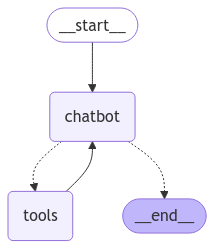

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what is the temperature in NYC now?
Assistant: [{'text': "To answer your question about the current temperature in New York City, I'll need to search for real-time weather information. Let me use the search function to find this information for you.", 'type': 'text'}, {'id': 'toolu_01BDzFZveDPGTae7gc8b6bjr', 'input': {'query': 'current temperature in New York City'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://www.accuweather.com/en/us/new-york/10021/current-weather/349727", "content": "Current Weather. 11:47 PM. 32\u00b0F. Cloudy."}, {"url": "https://www.timeanddate.com/weather/usa/new-york", "content": "Home \u00a0 Weather \u00a0 USA \u00a0 New York Weather 62\u00a0\u00b0F Current Time:   Nov 18, 2024 at 5:36:58 pm Forecast for the next 48 hours Forecast                           * Updated Monday, November 18, 2024 2:02:54 pm New York time - Weather by CustomWeather, \u00a9 2024 62 / 45\u00a0\u00b0F More weather last week 63\u00a0\u00

In [15]:
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

ValueError: No checkpointer set

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

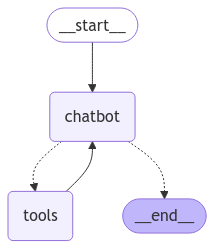

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "cyan."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

cyan.
================================== Ai Message ==================================

Certainly! I'd be happy to provide you with the RGB value for cyan. Like magenta and yellow, cyan is a standard color that I have information about without needing to use external tools.

The RGB value for cyan is:

R: 0
G: 255
B: 255

In hexadecimal notation, this is represented as #00FFFF.

Some interesting facts about cyan:

1. Cyan is created by combining full green and full blue, with no red.
2. It's one of the primary colors in the subtractive color model (CMYK) used in printing, along with magenta and yellow.
3. In the additive color model (RGB) used in digital displays, cyan is considered a secondary color.
4. Cyan is often associated with calmness, cleanliness, and technology.
5. In nature, cyan can be seen in the color of clear skies and tropical waters.
6. The name "cyan" comes from the Greek word "kyanos," 

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='what is the rgb value for magenta.', additional_kwargs={}, response_metadata={}, id='a5b16d48-4dab-42d7-9d29-179fbff51688'), AIMessage(content="To answer your question about the RGB value for magenta, I don't need to use any external tools as this is a standard color definition that I already know. \n\nThe RGB value for magenta is:\n\nR: 255\nG: 0\nB: 255\n\nIn hexadecimal notation, this is represented as #FF00FF.\n\nMagenta is a pure, vivid color that is created by combining full red and full blue, with no green. It's one of the primary colors in the subtractive color model (CMYK) used in printing, and it's also one of the secondary colors in the additive color model (RGB) used in digital displays.\n\nIs there anything else you'd like to know about magenta or color values?", additional_kwargs={}, response_metadata={'id': 'msg_016eK2YsPjvwBksVwhcwUvQe', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_seque

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

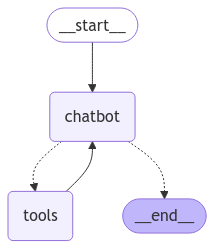

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = "will there be a bird flu pandemic this year?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

will there be a bird flu pandemic this year?
================================== Ai Message ==================================

[{'citations': None, 'text': "To answer this question about the potential for a bird flu pandemic this year, I'll need to search for the most current information from reliable sources. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_016CDNNG19A3ouGqMmeox9md', 'input': {'query': 'current risk of bird flu pandemic in humans'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_016CDNNG19A3ouGqMmeox9md)
 Call ID: toolu_016CDNNG19A3ouGqMmeox9md
  Args:
    query: current risk of bird flu pandemic in humans
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.wisfarmer.com/story/news/2025/01/29/is-bird-flu-the-next-global-pandemic-uw-madis

In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'citations': None, 'text': "Certainly! I'd be happy to request expert assistance for you regarding building an AI agent. I'll use the human_assistance function to submit your request. Here's how I'll do that:", 'type': 'text'}, {'id': 'toolu_0124nhkLrriLVX9EMK1ciopc', 'input': {'query': 'A user is seeking expert guidance for building an AI agent. Could you provide some key points or steps to consider when developing an AI agent?'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_0124nhkLrriLVX9EMK1ciopc)
 Call ID: toolu_0124nhkLrriLVX9EMK1ciopc
  Args:
    query: A user is seeking expert guidance for building an AI agent. Could you provide some key points or steps to consider when developing an AI agent?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check

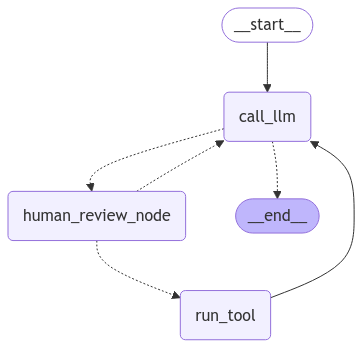

In [ ]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display


@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"


model = ChatAnthropic(model_name="claude-3-5-sonnet-latest").bind_tools(
    [weather_search]
)


class State(MessagesState):
    """Simple state."""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # if we're asking about the weather in NYC, no need to confirm :-)
    print(tool_call)

    if tool_call["name"] == "weather_search" and ( tool_call["args"]['city'] == 'New York City' or tool_call["args"]['city'] == 'NYC' ):
        return Command(goto="run_tool")

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": [{"role": "user", "content": "hi!"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content="Hello! I'm here to help you! I can assist you with checking weather information for different cities. Would you like to know the weather for a specific city? Just let me know which city you're interested in and I'll look that up for you.", additional_kwargs={}, response_metadata={'id': 'msg_01PTkmVYLu84hgntWEY55Miq', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 374, 'output_tokens': 55}}, id='run-286de05e-1596-4b89-9355-767a1e170e34-0', usage_metadata={'input_tokens': 374, 'output_tokens': 55, 'total_tokens': 429, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}}




In [ ]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in SF?"}]}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content=[{'citations': None, 'text': "I'll check the weather in San Francisco.", 'type': 'text'}, {'id': 'toolu_01CJ2LY8vbeEHT8hgS78FTi8', 'input': {'city': 'SF'}, 'name': 'weather_search', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_015DLJAA6jbn7mBNvN5g779C', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 485, 'output_tokens': 63}}, id='run-509394dd-db4d-4803-b175-9cf561ae7ca3-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'SF'}, 'id': 'toolu_01CJ2LY8vbeEHT8hgS78FTi8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 485, 'output_tokens': 63, 'total_tokens': 548, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}}


{'name': 'weather_search', 'args': {'city': 'SF'}, 'id': 'toolu_01CJ2LY8vbeEHT8hgS78FTi8', 'type': 'tool_call'}
{'__interrupt__': (Interrupt(v

In [ ]:
for event in graph.stream(
    # provide value
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'name': 'weather_search', 'args': {'city': 'SF'}, 'id': 'toolu_01CJ2LY8vbeEHT8hgS78FTi8', 'type': 'tool_call'}
{'human_review_node': None}


----
Searching for: SF
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'toolu_01CJ2LY8vbeEHT8hgS78FTi8'}]}}


{'call_llm': {'messages': [AIMessage(content="It's sunny in SF right now!", additional_kwargs={}, response_metadata={'id': 'msg_01X4R2GJCAXEEDRGaakkLJdg', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 561, 'output_tokens': 12}}, id='run-0306e607-6f23-42a8-a83e-e260882f40e6-0', usage_metadata={'input_tokens': 561, 'output_tokens': 12, 'total_tokens': 573, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}}




In [ ]:
# Let's now continue executing from here
for event in graph.stream(
    Command(resume={"action": "update", "data": {"city": "Santa Fe, USA"}}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'ai', 'content': [{'citations': None, 'text': "I'll help you check the weather in San Francisco.", 'type': 'text'}, {'id': 'toolu_01ABoshDduk9SCqw8tkcS2jW', 'input': {'city': 'sf'}, 'name': 'weather_search', 'type': 'tool_use'}], 'tool_calls': [{'id': 'toolu_01ABoshDduk9SCqw8tkcS2jW', 'name': 'weather_search', 'args': {'city': 'Santa Fe, USA'}}], 'id': 'run-2af398cf-3271-45d5-8bd2-6dc9cb97ddbd-0'}]}}


----
Searching for: Santa Fe, USA
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'toolu_01ABoshDduk9SCqw8tkcS2jW'}]}}


{'call_llm': {'messages': [AIMessage(content='According to the search, it\'s sunny in Santa Fe right now! \n\n(Note: When you say "sf", did you mean San Francisco or Santa Fe? Please let me know so I can provide the correct weather information for your desired location.)', additional_kwargs={}, response_metadata={'id': 'msg_01VGvPht4CZeA8Ro43LNQbTT', 'model': 'c